In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

## Получение данных, первичная обработка

In [6]:
df = pd.read_csv("D:\Python\german_credit_data.xls")

In [7]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


Первый столбец это индекс, который можно удалить

Проверка столбцов на пропущенные значения

In [8]:
df.drop(df.columns[0], inplace = True, axis = 1)
print("База данных содержит {} событий (клиентов) и {} столбцов (атрибутов).".format(df.shape[0],df.shape[1]))
print("Пропущенных значений в каждой колонке:\n{}".format(df.isnull().sum()))
print("Типы данных в столбцах:\n{}".format(df.dtypes))

База данных содержит 1000 событий (клиентов) и 9 столбцов (атрибутов).
Пропущенных значений в каждой колонке:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
Типы данных в столбцах:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


В 2 колонках имеются пропущенные значения. Вероятно, это люди, которые не имеют какого-либо из указаных счетов.

В данных присутствуют 3 числовые переменные и 5 категориальных

Посмотрим уникальные значения

In [10]:
n_unique = df.nunique()
n_unique

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64

In [11]:
for col in df.select_dtypes(include=[object]):
    print(col, " : ", df[col].unique())

Sex  :  ['male' 'female']
Housing  :  ['own' 'free' 'rent']
Saving accounts  :  [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account  :  ['little' 'moderate' nan 'rich']
Purpose  :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


## Предварительный анализ данных

In [15]:
def scatters(df, h=None, pal = None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount", y="Duration", hue = h, palette = pal , data=df, ax=ax1)
    sns.scatterplot(x="Age", y="Credit amount", hue = h, palette = pal , data=df, ax=ax2)
    sns.scatterplot(x="Age", y="Duration", hue = h, palette = pal , data=df, ax=ax3)
    plt.tight_layout()

Посмотрим на scatterplots 3 числовых переменных, стратифицированных по полу.

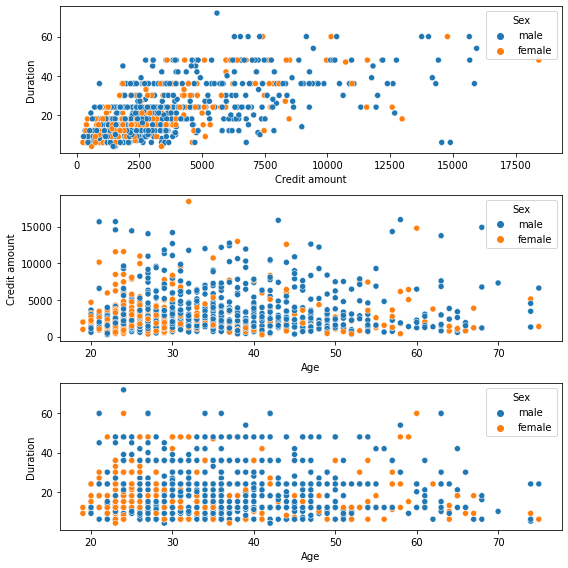

In [16]:
scatters(df, h="Sex")

Верхний график показывает, что четкой разницы в продолжительности и сумме кредита между мужчкинами и женщинами нет. Скорее всего существует положительная корреляция между продолжительностью и суммой кредита, что имеет смысл. 

Посмотрим линейную корреляцию между суммой кредита и сроком действия

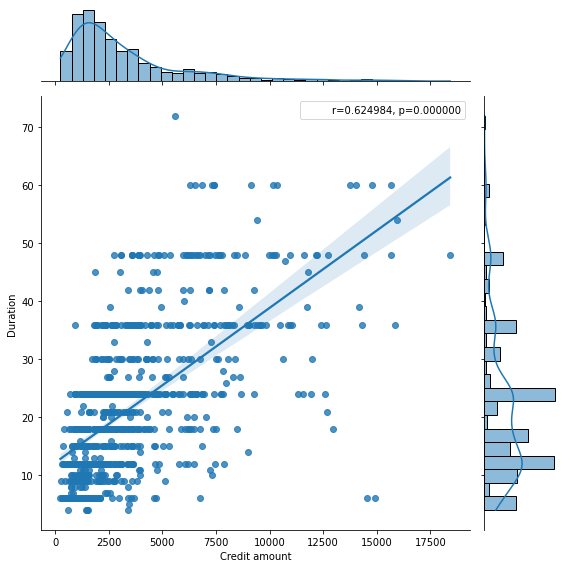

In [20]:
import scipy.stats as stats
r1 = sns.jointplot(x="Credit amount",y="Duration", data=df, kind="reg", height=8)
r, p = stats.pearsonr(df["Credit amount"], df["Duration"])
#r1.annotate(stats.pearsonr)
phantom, = r1.ax_joint.plot([], [], linestyle="", alpha=0)
r1.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])

Приведенный выше график показывает линейную корреляцию со значением Пирсона 0,62 и очень маленьким (практически нулевым) p-значением. Обычно люди берут большие кредиты на более длительные периоды. Ниже проанализируем графики линейной регрессии с различными категоризациями.

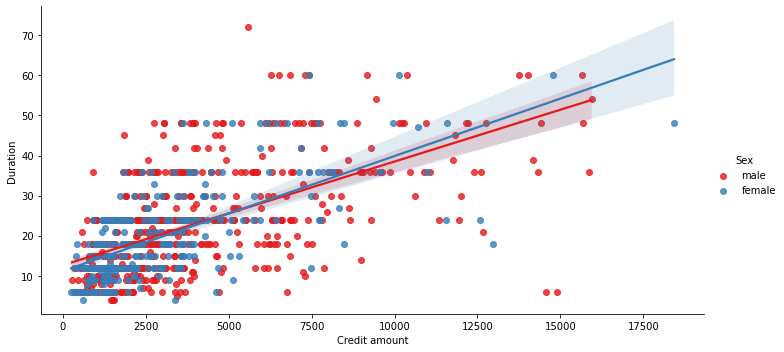

In [21]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=df, palette="Set1", aspect=2)
plt.show()

График выше показывает, что значимой разницы между мужчинами и женщинами нет

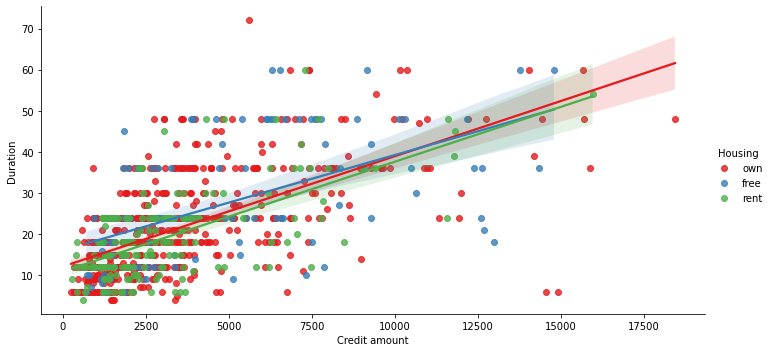

In [23]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=df, palette="Set1", aspect=2)
plt.show()

Приведенный выше график аналогичным образом показывает, что нет никакой разницы между категориями жилья.

Ниже посмотрим область бизнеса, где выдано наибольшее количество кредитов.

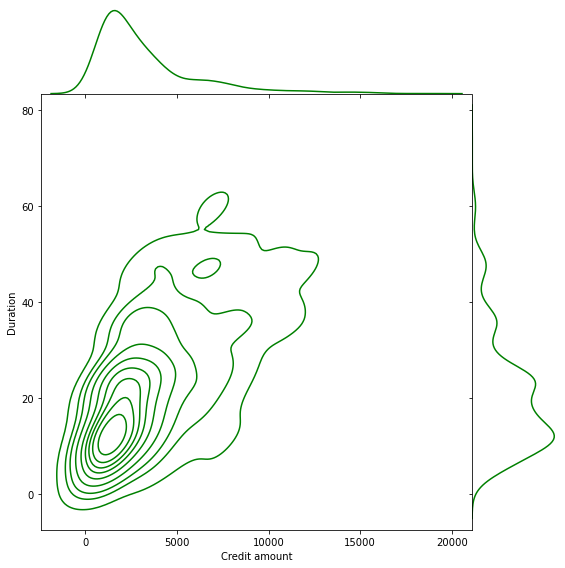

In [24]:
sns.jointplot("Credit amount","Duration", data=df, kind="kde", space=0, color="g",  height=8)
plt.show()

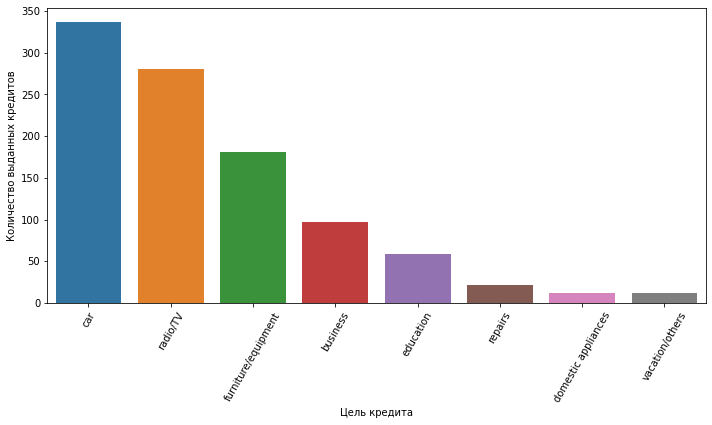

In [30]:
n_credits = df.groupby("Purpose")['Age'].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Количество выданных кредитов")
plt.xlabel("Цель кредита")
plt.tight_layout()

Гистограмма выше показывает, сколько кредитов было предоставлено на различные цели. Большая часть кредитов была выдана на авто и радио/телевидение.

Теперь сгенерируем бокс-графики для детального анализа категориальных переменных.

In [33]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x, y=y, hue=h, data = df)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom = 0.2)
    plt.tight_layout()

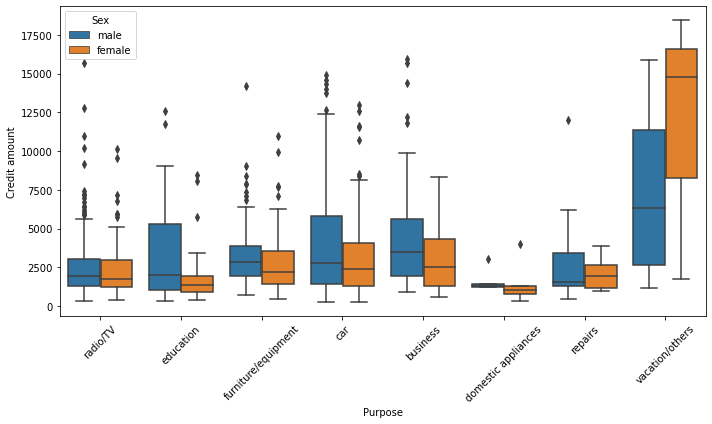

In [34]:
boxes("Purpose","Credit amount","Sex")

График выше показывает, что самые большие суммы берутся на отпуск / другие расходы, самые маленькие - на бытовую технику. Большинство из них имеют выбросы в верхней части ячеек (более высокие суммы). В большинстве случаев нет никакой разницы между мужчинами и женщинами, несмотря на категорию отпуск/другие. Но следует помнить, что в этой категории было выдано очень небольшое количество кредитов.

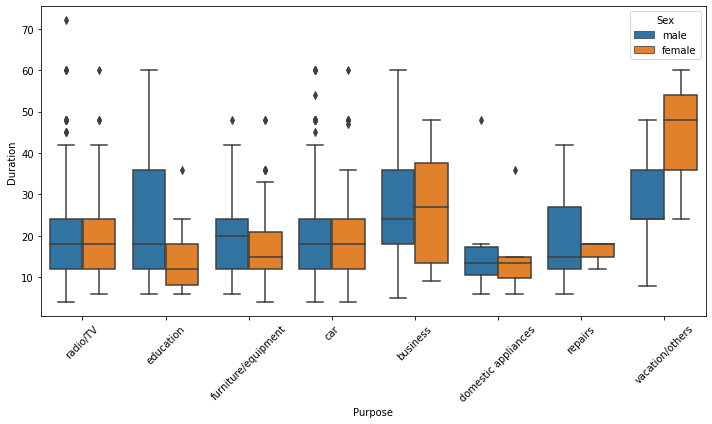

In [35]:
boxes("Purpose","Duration","Sex")

Приведенный выше график показывает, что, как правило, нет разницы в продолжительности кредита между мужчинами и женщинами. Мы также не видим четкой тенденции между категориями с наблюдениями о том, что наименьший срок службы приходится на бытовую технику. Это имеет смысл, поскольку согласуется с выводами из предыдущего графика (сумма кредита) – в этой категории самые низкие суммы кредитов.

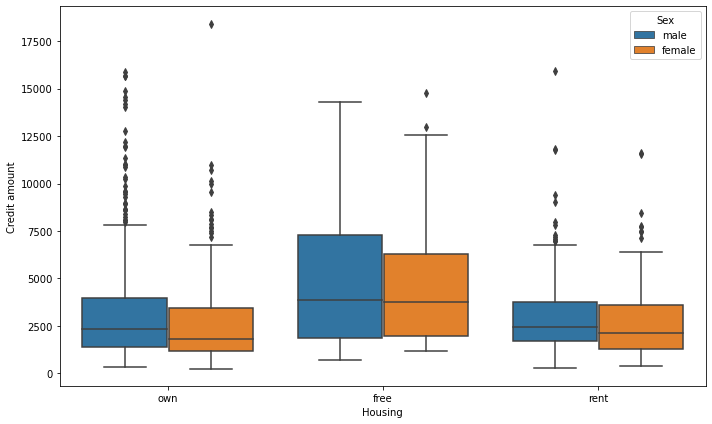

In [36]:
boxes("Housing","Credit amount","Sex",r=0)

С точки зрения категории жилья, большой разницы нет, несмотря на то, что люди, имеющие “бесплатное” жилье, как правило, берут несколько большие суммы кредитов.

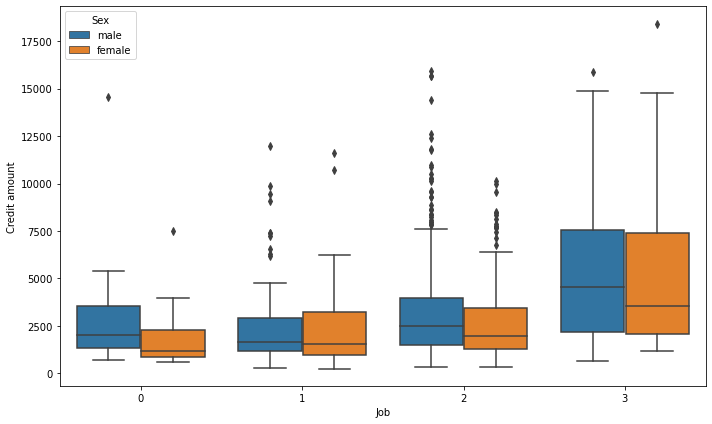

In [37]:
boxes("Job","Credit amount","Sex",r=0)

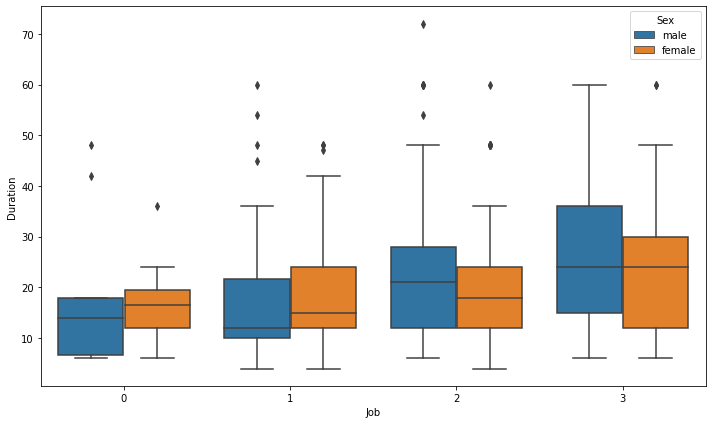

In [38]:
boxes("Job","Duration","Sex",r=0)

С точки зрения категории работы, опять же, нет разницы между мужчинами и женщинами, но мы можем видеть, что работа категории 3, как правило, требует больших сумм кредита на более длительный срок.

## Clustering with KMeans

Для кластеризации cоздадим подмножество, содержащее только числовые переменные (возраст, сумма кредита, продолжительность)

In [40]:
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = df.loc[:,selected_cols]

In [41]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

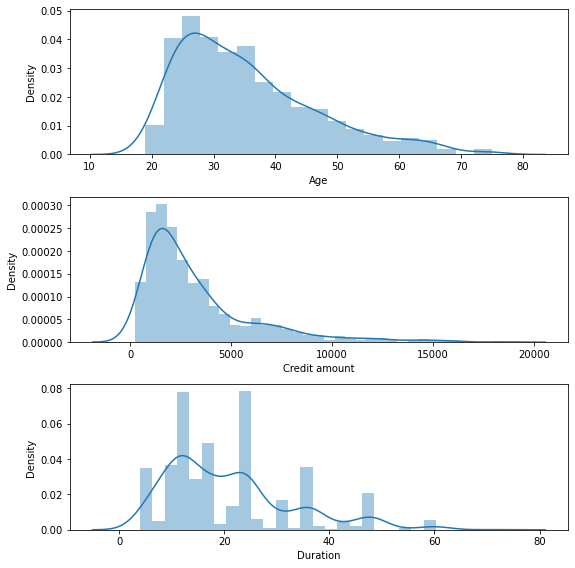

In [42]:
distributions(cluster_data)

Мы можем видеть, что распределения смещены вправо. Чтобы получить лучшие результаты, мы должны устранить асимметрию с помощью логарифмического преобразования. После этого посмотрим, как они выглядят.

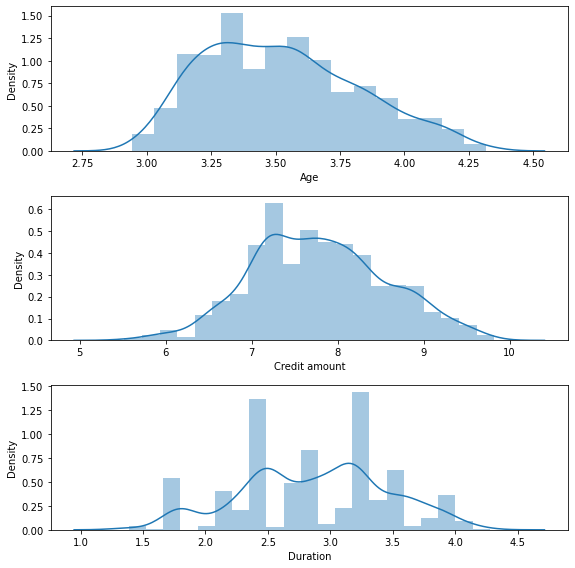

In [43]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

Следующим шагом будет центрирование и масштабирование переменных – этого требует алгоритм KMeans. Мы будем использовать для этого StandardScaler из библиотеки sklearn.

In [44]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

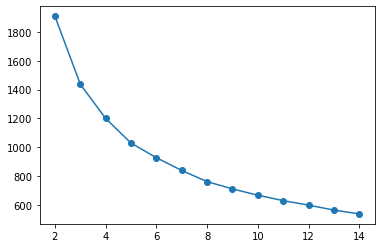

In [45]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

Приведенный выше график показывает, что инерция уменьшается с увеличением числа кластеров.

Этот метод позволяет оценить разделение кластеров и поместить каждое наблюдение в свой собственный кластер. Чем больше баллов, тем лучше. Проведем этот анализ для различных семян.

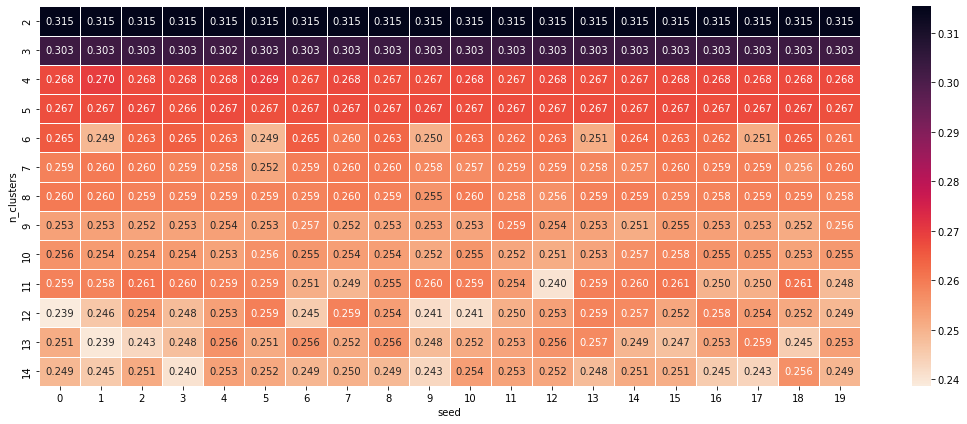

In [46]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

На тепловой карте выше показаны оценки силуэта для различных комбинаций случайного состояния и количества кластеров. Самые высокие оценки получены для кластеров 2 и 3, и они относительно нечувствительны к случайному состоянию.

Используем 3 кластера, чтобы получить больше информации о данных.

In [47]:
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

Ниже я создам силуэтный график для 3 кластеров, чтобы визуально отобразить соответствие каждой точки внутри ее собственного кластера (модифицированный код из scikit-learn doc).

For n_clusters = 3  and seed = 19 
The average silhouette_score is : 0.30255813750380023


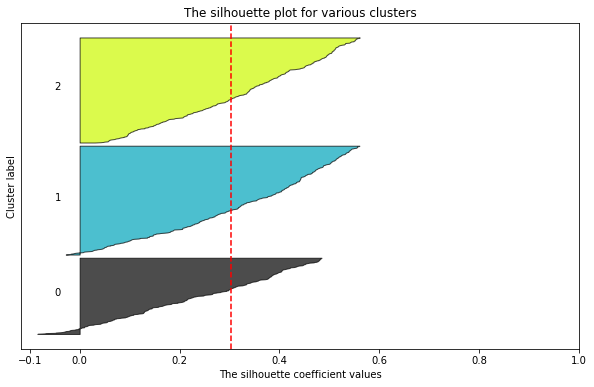

In [48]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=3, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 3," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

Кластеры на scatterplot

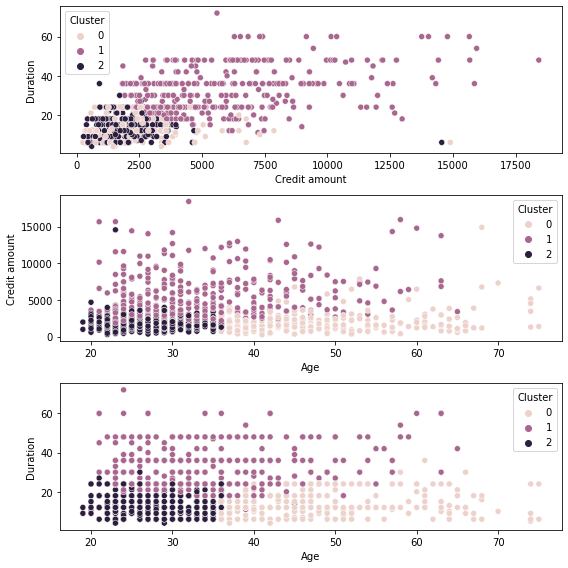

In [49]:
scatters(clustered_data, 'Cluster')

Графики выше показывают три созданных кластера. Два нижних показывают относительно четкое разделение кластеров, но на верхнем это не так заметно.

Cгенерируем график тепловой карты для упрощения бизнес-интерпретации сегментации клиентов.

In [50]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,48.5,1970.3,13.9
1,34.0,5665.4,32.2
2,27.7,1736.3,14.3


Кластер 0 – меньшая средняя сумма кредита, короткий срок, клиенты высокого возраста

Кластер 1 – высокая средняя сумма кредита, длительный срок, клиенты среднего возраста

Кластер 2 - более низкая средняя сумма кредита, короткий срок, молодые клиенты

## Clustering with Affinity Propagation

В этом алгоритме есть два релевантных параметра: предпочтение и сброс. Это означает, что мы не определяем заранее количество кластеров, алгоритм сам выбирает их количество. Я исправлю сброс и проверю количество кластеров в функции параметра предпочтения.

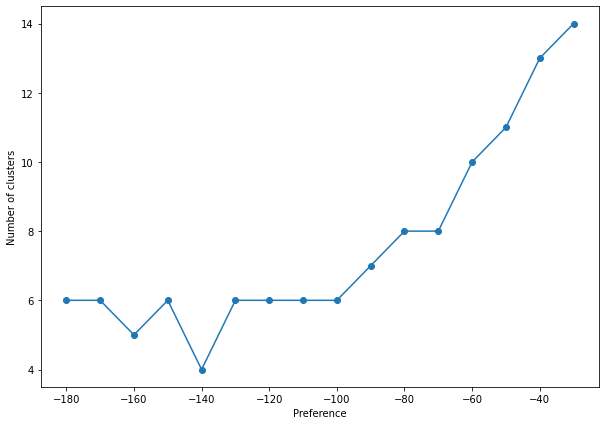

In [51]:
preferences = np.arange(-30,-190,-10)
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Preference")
plt.ylabel("Number of clusters")
plt.plot(preferences,clusters, marker='o')

Вместе с уменьшением значения параметра предпочтения количество кластеров также уменьшается и выравнивается при очень малых значениях предпочтения. Я проверю вариант с четырьмя кластерами.

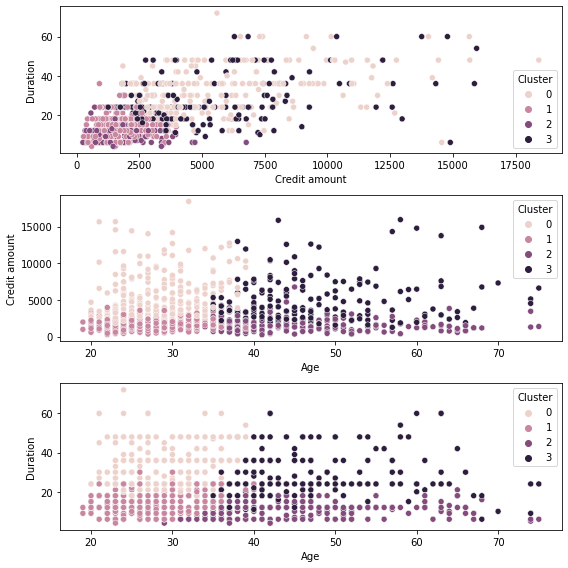

In [52]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af.labels_)
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data_af = cluster_data.assign(Cluster=labels_af)
scatters(clustered_data_af,'Cluster')

grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)

In [53]:
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)
grouped_af

,Age,Credit amount,Duration
Cluster,,,
0,28.7,5593.7,32.2
1,27.9,1654.3,15.1
2,46.0,1551.7,10.7
3,47.5,4977.9,27.6


Кластер 0 – высокая средняя сумма кредита, длительный срок действия, молодые клиенты

Кластер 1 – низкая средняя сумма кредита, короткий срок, молодые клиенты

Кластер 2 - низкая средняя сумма кредита, короткий срок, высокий средний возраст

Кластер 3 - высокая средняя сумма кредита, средняя продолжительность, высокий средний возраст